In [ ]:
pip install numpy pandas matplotlib scipy fastdtw yfinance seaborn

In [35]:
import pandas as pd, matplotlib.pyplot as plt, yfinance as yf, seaborn as sns
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

## DTW

### Takes yfinance tickers; from this it can plot joint distributions and generate DTW relationships

In [46]:
class DTW:
    def __init__(self, series_list, sd, ed, interval):
        self.interval=interval
        self.series_list = series_list
        self.sd = sd
        self.ed = ed
        self.prices = {}  # To store price data
        self.returns = {}  # To store return data
        self.path = []
        self.names = {} # To store names

    def get_price_data(self):
        """
        Generates dictionary of prices
        """
        for series in self.series_list:
            stock = yf.Ticker(series)
            close = yf.download(series, start=self.sd, end=self.ed, interval=self.interval)['Close']
            self.prices[series] = close
            self.names[series] = stock.info['shortName']  # Fetch and store the stock name

        
        return self.prices
            
    def get_return_data(self):
        """
        Generates dictionary of price returns
        """
        # Ensure price data is available; if not, fetch it first
        if not self.prices:
            self.get_price_data()
        for series, close in self.prices.items():
            self.returns[series] = np.log(close / close.shift(1)).dropna()
        
        return self.returns
        
    def pairplot_returns(self):
        """
        Generates a matrix of pairplots to compare return distributions
        """
        # Ensure price data is available; if not, fetch it first
        if not self.returns:
            self.get_return_data()
        returns_df=pd.DataFrame(self.returns)
        g=sns.pairplot(returns_df)
        g.map_upper(sns.kdeplot, levels=4, color=".2")
        plot_kws={"s": 1}

    def get_cost_matrix(self,ticker1,ticker2):
        """
        Generates numpy array of warp costs
        """
        if not self.returns:
            self.get_return_data()
            
        if not (ticker1 in (list(self.returns.keys())) and ticker1 in (list(self.returns.keys()))):
            return "series not in series_list"
                                                                    
        series1, series2 = self.returns[ticker1], self.returns[ticker2]  
        distance = np.zeros((len(series1), len(series2)))
        for k in range(len(series1)):
            for l in range(len(series2)):
                distance[k,l] = (series1[k]-series2[l])**2

        costs = np.zeros((len(series1), len(series2)))
        costs[0,0] = distance[0,0]
        
        for i in range(1, len(series2)):
            costs[i, 0] = distance[i, 0] + costs[i-1, 0]  
            
        for j in range(1, len(series1)):
            costs[0, j] = distance[0, j] + costs[0, j-1]  
    
        # Accumulated warp path cost
        for i in range(1, len(series2)):
            for j in range(1, len(series1)):
                costs[i, j] = min(
                    costs[i-1, j],    # insertion
                    costs[i, j-1],    # deletion
                    costs[i-1, j-1]   # match
                ) + distance[i, j] 
                
        return costs
    
    def warp_plot(self, ticker1, ticker2):
        """
        Generates a heat map that chooses a warp path based on a path of least resistance through the accumulated cost matrix
        """
        if not self.returns:
            self.get_return_data()
            
        if not (ticker1 in (list(self.returns.keys())) and ticker1 in (list(self.returns.keys()))):
            return "series not in series_list"

        series1 = self.returns[ticker1]
        series2 = self.returns[ticker2]

        if len(series1) == 0 or len(series2) == 0:
            return "One of the series is empty"
        
        distance, path = fastdtw(series1, series2, dist=2)
        cost_matrix = self.get_cost_matrix(ticker1, ticker2)

        self.path=path
        
        fig, ax = plt.subplots(figsize=(15, 7))
        ax = sns.heatmap(cost_matrix, square=True, linewidths=0.1, ax=ax)
        ax.invert_yaxis()
        
        # Get the warp path in x and y directions
        path_x = [p[0] for p in path]
        path_y = [p[1] for p in path]
        
        # Align the path from the center of each cell
        path_xx = [x + 0.5 for x, y in path]
        path_yy = [y + 0.5 for x, y in path]
        
        ax.plot(path_xx, path_yy, color='black', linewidth=2, alpha=1)

    def warp_crosssection(self,ticker1,ticker2):
        """
        Generates same heatmap as warp_plot
        And plots a crosssectional of the time series with lines linking the corresponding points
        """
        self.warp_plot(ticker1,ticker2)
            
        if not (ticker1 in (list(self.returns.keys())) and ticker1 in (list(self.returns.keys()))):
            return "series not in series_list"
        
        x = self.returns[ticker1]
        y = self.returns[ticker2]
        
        offset= self.returns[ticker1].max() - self.returns[ticker2].min()
        y_offset = y + offset
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        ax.plot(x.index, x.values, '-ro', label=ticker1, linewidth=1, markersize=5, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
        
        ax.plot(y.index, y_offset.values, '-bo', label=f'{ticker2} (offset)', linewidth=1, markersize=5, markerfacecolor='skyblue', markeredgecolor='skyblue')
        ax.grid(False)
        
        ax.legend()
        ax.set_xlabel('Date')
        ax.set_ylabel(f'{self.names[ticker1]} Return')
        ax.set_title(f'DTW Mapping Between {self.names[ticker1]} and {self.names[ticker2]}')
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))
        
        ax1=ax.twinx()
        # Get the current limits of the primary y-axis
        min_y, max_y = ax.get_ylim()
        
        # Set the secondary y-axis limits, shifted upwards by 0.2
        ax1.set_ylim(min_y - offset, max_y - offset)

        ax1.set_ylabel(f'{self.names[ticker2]} Return')

        ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))
        ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1))
        
        # Add a solid line at zero on the primary axis
        ax.axhline(0, color='black', linewidth=1)
        
        # Add a solid line at zero on the secondary axis
        ax1.axhline(0, color='black', linewidth=1)

        # Draws lines connecting corresponding points
        if hasattr(self, 'path'):
            for map_x, map_y in self.path:
                ax.plot([x.index[map_x], y.index[map_y]], [x.values[map_x], y_offset.values[map_y]], '-b', linewidth=0.5, alpha=1)
            
        plt.show()

### Mag 7 joint plot

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


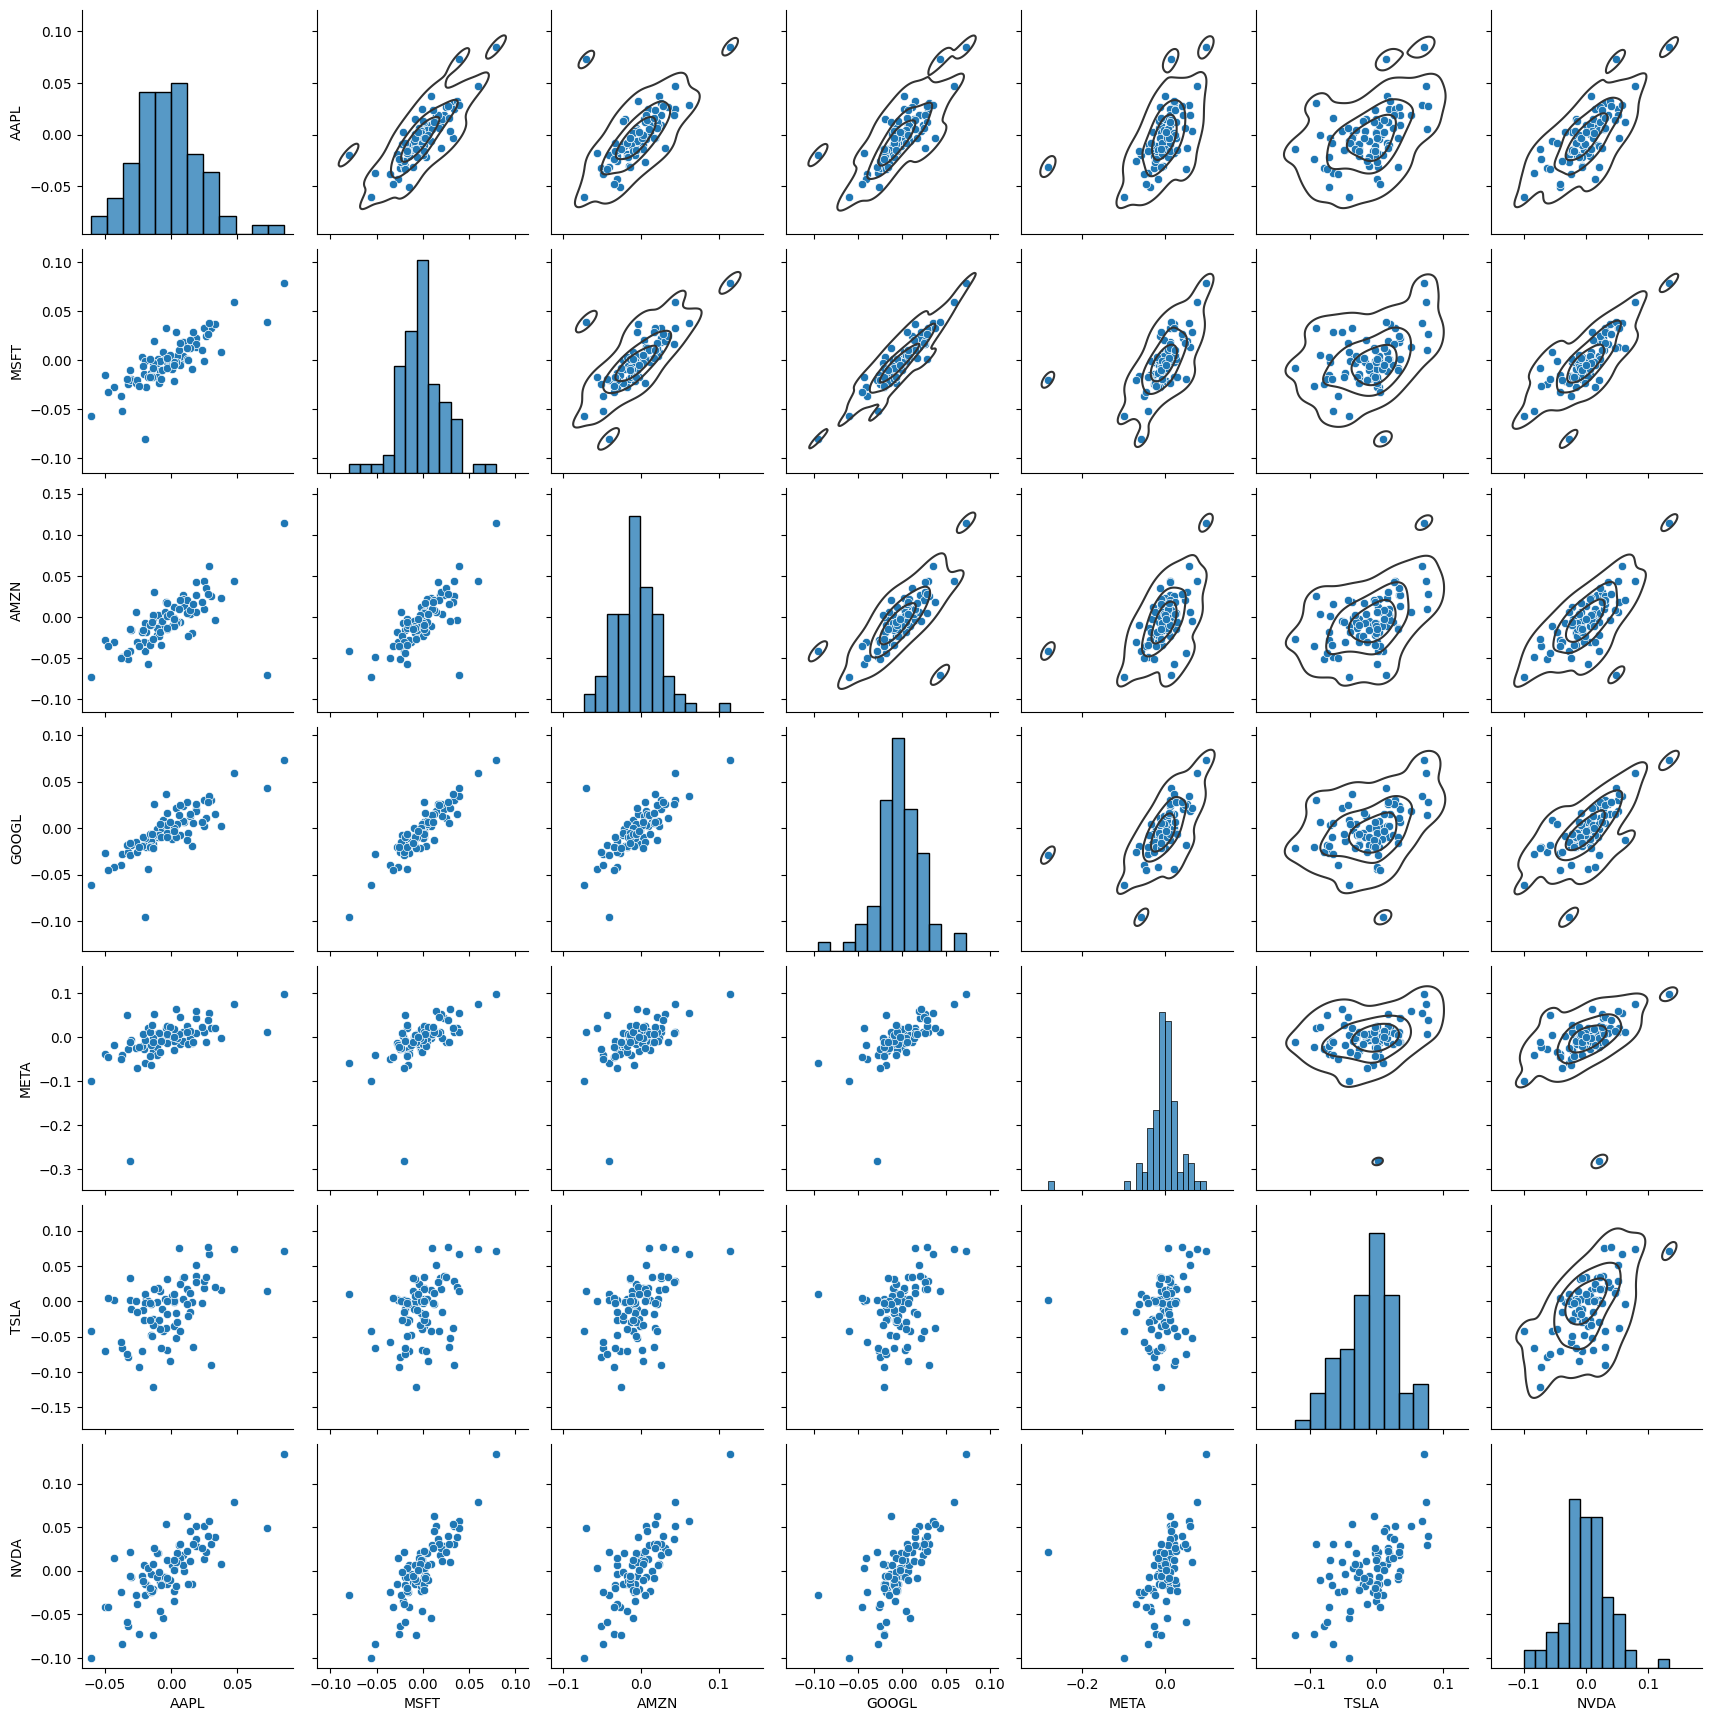

In [53]:
Mag7_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA']
Mag7=DTW(Mag7_tickers,'2022-09-01', '2023-01-01','1d')
Mag7.pairplot_returns()

### Ford and TSLA DTW Relationship

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/q0/bhv0fltj65v16qxbdhlcmjc80000gn/T/ipykernel_29102/1639114475.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distance[k,l] = (series1[k]-series2[l])**2


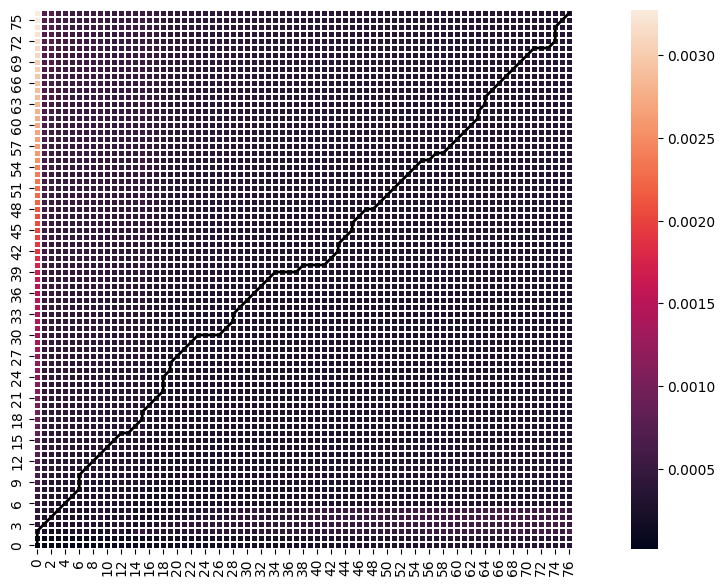

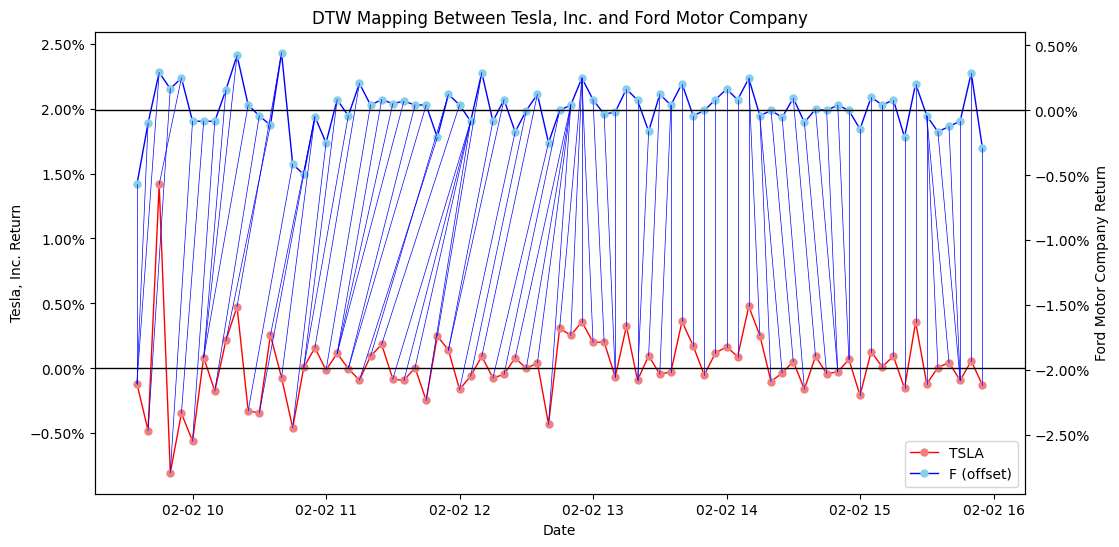

In [52]:
Ford_and_Tesla=DTW(['TSLA', 'F'],'2024-02-02', '2024-02-03', '5m')
Ford_and_Tesla.warp_crosssection('TSLA','F')